<font color="#de3023"><h1><b>REMINDER MAKE A COPY OF THIS NOTEBOOK, DO NOT EDIT</b></h1></font>

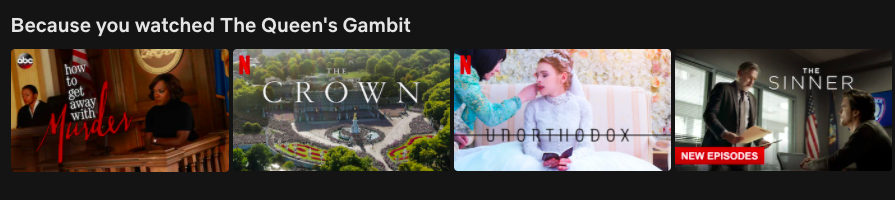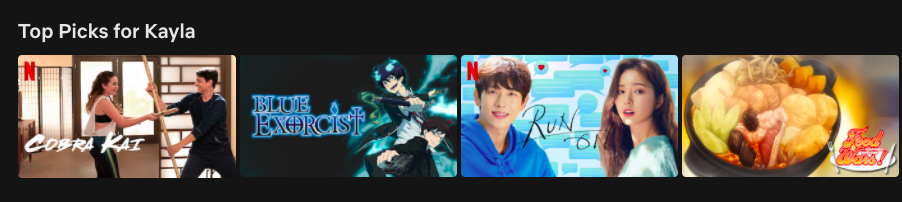

# Recap and where we're going!

In the last notebook, we looked at how to predict top hits for music tracks and explored our music data set from Spotify. Today, you and your group are going to build an AI tool that can help recommend new content based on similar content. We'll start by understanding our problem, identifying:
* What are recommender systems? How are they used?
* What are some different types of recommender systems?
* What kind of data is used to implement one?

Once we have all of this information, we will take a step back and plan our system design.

In this notebook we will be:
1.   Talking about what recommender systems are and why we use them
2.   Implementing popular recommendations by genre
3.   Implementing content-based recommendation
4.   (Optional) Deploying our model with Streamlit!



In [ ]:
#@title Run this to download data and prepare our environment! { display-mode: "form" }

# importing packages and dataset
# import gdown
import ast
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances
from IPython import display
import ipywidgets as widgets
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

# music_data_url = 'https://drive.google.com/uc?id=1Q4UAv4FPPOlhmFWHkn4Y83dG6M51xnoM'
!wget 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Music%20Recommendation/data_with_most_lyrics.csv'
music_data_path = './data_with_most_lyrics.csv'
# gdown.download(music_data_url, music_data_path, True)

music_data = pd.read_csv(music_data_path)
music_data = music_data.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.2'])
music_data['lyrics'] = music_data['lyrics'].str.replace('\n', ' ')
available_songs = music_data["track_name"] + ', ' + music_data["artist_name"]
available_songs = available_songs.tolist()


# past_data_url = 'https://drive.google.com/uc?id=1MIkOcP2JY_foloYAR5-Y60YyRVbRhQMs'
!wget 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Music%20Recommendation/spotify_data_urls.csv'
past_data_path = './spotify_data_urls.csv'
# gdown.download(past_data_url, past_data_path , True)

## Load in data
past_data = pd.read_csv(past_data_path)


class Error(Exception):
    """Base class for other exceptions"""
    pass

class NotSeparableError(Error):
    """Raised when the input value is too small"""
    pass

def fix_genres(row):
  row_new = row['genres'].replace(',', '')
  row_new = row_new.replace("'", "")
  row_new = row_new.replace('"', "")
  if len(row_new)!=0 and row_new[0]=='[':
    return row_new[1:-1]
  return row_new

def find_title_from_index(index):
    return music_data["track_name"][index]
def find_artist_from_index(index):
    return music_data["artist_name"][index]
def find_index_from_title(track_name):
    return music_data.index[music_data.track_name == track_name].values[0]





--2024-08-20 13:53:36--  https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Music%20Recommendation/data_with_most_lyrics.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.26.207, 173.194.212.207, 172.217.204.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.26.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11776786 (11M) [application/vnd.ms-excel]
Saving to: ‘data_with_most_lyrics.csv’

data_with_most_lyri 100%[===================>]  11.23M  --.-KB/s    in 0.1s    

2024-08-20 13:53:37 (117 MB/s) - ‘data_with_most_lyrics.csv’ saved [11776786/11776786]

--2024-08-20 13:53:37--  https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Music%20Recommendation/spotify_data_urls.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.26.207, 173.194.212.207

# Milestone 1: What are Recommender Systems and why do we use them?

There are three main types of recommender systems that are used:
1. **Popular Recommendations**: Recommending things that are known to be popular or well rated
2. **Content-Based Filtering**: Recommending things based on a similar item you bought or looked at
3. **Collaborative Filtering**: Recommending things based on what similar people have bought or looked at

In this notebook, we'll be focused on **content-based filtering**.

## Exercise (Discussion)

* **What are some of the potential benefits or drawbacks to each of the three methods mentioned above?**

* **When might it be a good idea to use one method instead of another?**

### Discussion Solutions
<details>
<summary>Click to reveal!</summary>

### Popular recommendations:
#### Pros:
- If a song is popular, it's very likely that the user will follow that trend.
#### Cons:
- If the user doesn't like popular music, it might not be the optimal recommendation.

### Content-Based recommendations:
#### Pros:
- Will be tailored to the user's listening patterns.
#### Cons:
- The user's listening history might have songs they didn't enjoy.

### Collaborative recommendations:
#### Pros:
- Allows users to find similar music to their current songs.
#### Cons:
- No guarantee the user will follow the trends of other similar people.

All of these systems have pros and cons so many applications use multiple or all of these!



## Exercise (Matching)
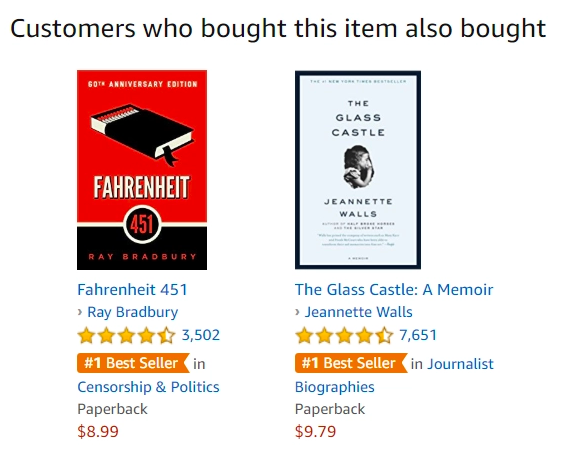


In [ ]:
#@title What is this an example of? { display-mode: "form" }

Example  = "fill in" #@param ["Popular Recommendations", "Collaborative Filtering", "Content Based Filtering","fill in"]

if Example == "Collaborative Filtering":
  print("Yes! This is an example of collaborative filtering.")
else:
  print("Try again!")

Try again!


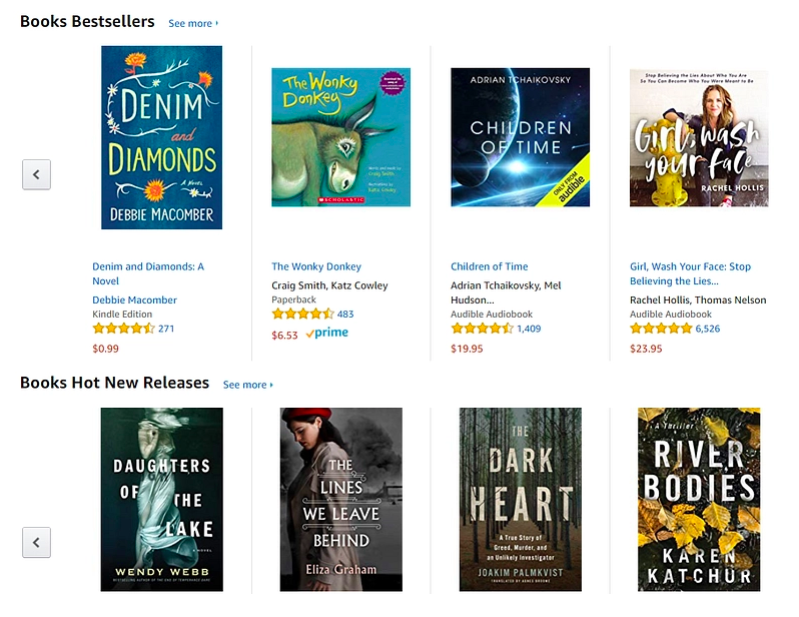

In [ ]:
#@title What is this an example of? { display-mode: "form" }

Example  = "fill in" #@param ["Popular Recommendations", "Collaborative Filtering", "Content Based Filtering","fill in"]

if Example == "Popular Recommendations":
  print("Yes! This is an example of using popular recommendations.")
else:
  print("Try again!")

Try again!


## Exercise (Discussion)


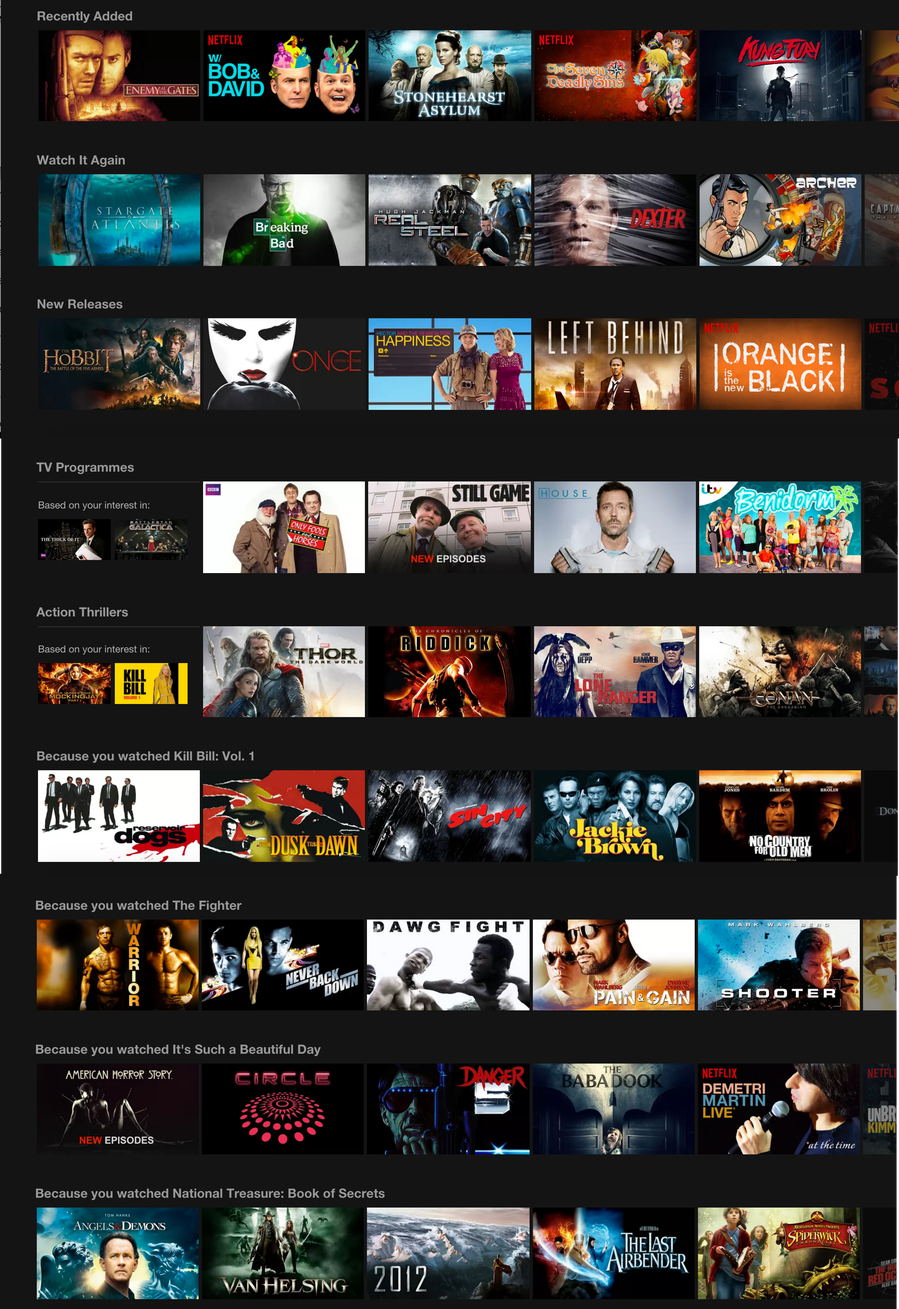

In [ ]:
#@title Which of these categories are examples of recommender systems? { display-mode: "form" }

Recently_Added = False #@param {type:"boolean"}
Watch_It_Again = False #@param {type:"boolean"}
New_Releases = False #@param {type:"boolean"}
TV_Programmes = False #@param {type:"boolean"}
Action_Thrillers = False #@param {type:"boolean"}
Because_you_watched_Kill_Bill_Vol_1 = False #@param {type:"boolean"}
Because_you_watched_The_Fighter = False #@param {type:"boolean"}
Because_you_watched_Its_Such_a_Beautiful_Day = False #@param {type:"boolean"}
Because_you_watched_National_Treasure_Book_of_Secrets = False #@param {type:"boolean"}

responses = [Recently_Added, Watch_It_Again, New_Releases, TV_Programmes, Action_Thrillers, Because_you_watched_Kill_Bill_Vol_1, Because_you_watched_The_Fighter, Because_you_watched_Its_Such_a_Beautiful_Day, Because_you_watched_National_Treasure_Book_of_Secrets]

if all(response == True for response in responses):
  print("""
  Yes! These are all examples of recommender systems. Even though the first five
  don't seem like recommendations, Netflix is still choosing the content there
  based on your interests!
  """)
else:
  print("Try again!")

Try again!


In [ ]:
#@title Which of these categories are using machine learning? { display-mode: "form" }

Recently_Added = False #@param {type:"boolean"}
Watch_It_Again = False #@param {type:"boolean"}
New_Releases = False #@param {type:"boolean"}
TV_Programmes = False #@param {type:"boolean"}
Action_Thrillers = False #@param {type:"boolean"}
Because_you_watched_Kill_Bill_Vol_1 = False #@param {type:"boolean"}
Because_you_watched_The_Fighter = False #@param {type:"boolean"}
Because_you_watched_Its_Such_a_Beautiful_Day = False #@param {type:"boolean"}
Because_you_watched_National_Treasure_Book_of_Secrets = False #@param {type:"boolean"}

responses = [Recently_Added, Watch_It_Again, New_Releases, TV_Programmes, Action_Thrillers, Because_you_watched_Kill_Bill_Vol_1, Because_you_watched_The_Fighter, Because_you_watched_Its_Such_a_Beautiful_Day, Because_you_watched_National_Treasure_Book_of_Secrets]

if all(response == True for response in responses):
  print("Yes! These are all examples of machine learning.")
else:
  print("Try again!")

Try again!


## Exercise (Discussion)
* **Why are recommender systems useful? You've already seen some examples of how they are used, but why do you think they are so widely used?**
* **Can you think of any more potential applications of recommender systems?**

### Discussion Solutions
<details>
<summary>Click to reveal!</summary>

1. Recommendation systems allow for users to receive more relevant content.
2. More relevant content leads to more consumption. This correlates to more ads and sales.
3. Some interesting applications of recommender systems include admissions in higher education, employment (LinkedIn), and restaurants.

</details>


# Milestone 2: Popular Recommendations!
First, we're going to work on a recommender system that will recommend popular songs by the genre they're in! The data we're using is similar to the data from the last notebook, but there are a few different features and some of the songs are different. Let's **print out the data (called `music_data`)** and take a look at the first five!

In [ ]:
### YOUR CODE HERE


In [ ]:
#@title Instructor Solution
music_data.head()

artist_name                           track_name  \
0      Miley Cyrus                  Party In The U.S.A.   
1  Waylon Jennings  The Year 2003 Minus 25 - Remastered   
2         Kid Cudi             Day 'N' Nite (nightmare)   
3           SHINee                       Ring Ding Dong   
4         Kid Cudi     Pursuit Of Happiness (Nightmare)   

                                     album                track_id  \
0                    The Time Of Our Lives  5Q0Nhxo0l2bP3pNjpGJwV1   
1                          Waylon & Willie  0sFq478LIo9BFwf2qzMzzF   
2          Man On The Moon: The End Of Day  5FEXPoPnzueFJQCPRIrC3c   
3  2009, Year Of Us - The Third Mini Album  4vLqN0bIxIQjlet2mIMBnx   
4          Man On The Moon: The End Of Day  5iSEsR6NKjlC9SrIJkyL3k   

   track_popularity  year  artist_popularity  artist_followers  \
0                74  2009                 89          14958283   
1                44  2009                 72            917987   
2                73  2009                 87           4787381   
3                59  2009                 73           2289681   
4                73  2009                 87           4787381   

                                              genres  danceability  ...  mode  \
0              ['dance pop', 'pop', 'post-teen pop']         0.652  ...     0   
1  ['country', 'country rock', 'outlaw country', ...         0.626  ...     1   
2                 ['hip hop', 'ohio hip hop', 'rap']         0.871  ...     0   
3                       ['k-pop', 'k-pop boy group']         0.835  ...     1   
4                 ['hip hop', 'ohio hip hop', 'rap']         0.630  ...     1   

   speechiness  acousticness  instrumentalness  liveness  valence    tempo  \
0       0.0420       0.00112          0.000115    0.0886    0.470   96.021   
1       0.0384       0.35500          0.000009    0.0668    0.474  102.166   
2       0.0761       0.49900          0.000004    0.1140    0.799  137.996   
3       0.0431       0.12500          0.000501    0.2220    0.811  124.980   
4       0.0414       0.48400          0.000093    0.2980    0.266  115.277   

   duration_ms  time_signature  \
0       202067               4   
1       184267               4   
2       221267               4   
3       233280               4   
4       295293               4   

                                              lyrics  
0  I hopped off the plane at L.A.X. with a dream ...  
1                                                NaN  
2  [Kid Cudi:] Day and night (what, what) I toss ...  
3  [Jonghyun] Baby Negae banhae beorin naegae wae...  
4  Crush a bit, little bit Roll it up, take a hit...  

[5 rows x 23 columns]

### Exercise (Coding)
First, let's take a closer look at the `genres` column. To practice using pandas dataframes, use the cell below to display only the `genres` column of the first five songs in `music_data`.

In [ ]:
# YOUR CODE HERE


In [ ]:
#@title Instructor Solution
music_data['genres'].head()

0                ['dance pop', 'pop', 'post-teen pop']
1    ['country', 'country rock', 'outlaw country', ...
2                   ['hip hop', 'ohio hip hop', 'rap']
3                         ['k-pop', 'k-pop boy group']
4                   ['hip hop', 'ohio hip hop', 'rap']
Name: genres, dtype: object

## Activity: Unique Values


### Exercise (Coding):
**How many unique albums are in the dataset?**

We can use the pandas function `.value_counts()` to see all of the unique items in a column of our data! Here's an example below of how to use it to find all of the unique albums.

In [ ]:
item_counts = music_data["album"].value_counts()
print(item_counts)

album
A State Of Trance Year Mix 2017 (Mixed by Armin van Buuren)    203
A State Of Trance Year Mix 2019 (Mixed by Armin van Buuren)    106
A State Of Trance Year Mix 2020 (Mixed by Armin van Buuren)    105
A State Of Trance Year Mix 2018 (Mixed by Armin van Buuren)    105
A State Of Trance Year Mix 2014 (Mixed by Armin van Buuren)    100
                                                              ... 
Rise Of An Empire (Deluxe Edition)                               1
Spotify Sessions (Live In New York / 2014)                       1
G I R L                                                          1
60 Summers                                                       1
Chinese New Year 2021: Year of the Buffalo                       1
Name: count, Length: 5200, dtype: int64


Now, let's use the `.value_counts()` function in the cell below to find all of the unique genres in the data set!

In [ ]:
# YOUR CODE HERE


In [ ]:
#@title Instructor Solution
item_counts = music_data["genres"].value_counts()
print(item_counts)

genres
[]                                                                                                            1964
['edm', 'pop dance', 'progressive house', 'progressive trance', 'trance', 'uplifting trance']                  170
['dutch trance', 'edm', 'pop dance', 'progressive house', 'trance']                                            153
['contemporary country', 'country', 'country road', 'modern country rock']                                     151
['dance pop', 'pop', 'post-teen pop']                                                                          141
                                                                                                              ... 
['australian dance', 'big room', 'edm', 'melbourne bounce', 'melbourne bounce international', 'pop dance']       1
['classic swedish pop']                                                                                          1
['tropical house', 'uk contemporary r&b']                                

### Exercise (Coding)
Hmm, was this what you expected? Since a song can have more than one genre, we have to do some pre-processing to separate the different genres before using `value_counts`. In our dataframe in `pandas`, the genres are stored as one giant string. The function below will turn the string into a list strings (the genres).

**input**: `"['space age pop', 'surf music']"` (`type = str`)

**output**: `['space age pop', 'surf music']` (`type = list`)

Run the cell below to initialize a helper function that will help us separate the different genres!

**Discuss**: Can you take a guess as to what each part of the code is doing? Feel free to do some research on [slicing](https://www.w3schools.com/python/python_strings_slicing.asp) and [splitting](https://www.w3schools.com/python/ref_string_split.asp)!

In [ ]:
def parse_string_into_list(string):
  return string[1:len(string)-1].split(', ')

Run the cell below to use your function in the `separate_values` function. `separate_values` takes in one parameter, the name of the column you're separating. Run the cell below to intialize it and click on the cell if you want to see the function inside!

In [ ]:
#@title Run this to use your string parser in the data frame!
def separate_values(column):
  mdata = music_data.copy()
  mdata[column] = mdata.apply(lambda row: parse_string_into_list(row[column]), axis=1)
  mdata.head()

  mdata = mdata.explode(column)
  return mdata

Now use the cell below to print out the data frame that you get as the result of the `separate_values` function with the `genres` column.

In [ ]:
# YOUR CODE HERE (replace the line below, then print it out)
separated_genres = None

In [ ]:
#@title Instructor Solution
separated_genres = separate_values('genres')
separated_genres.head()

artist_name                           track_name  \
0      Miley Cyrus                  Party In The U.S.A.   
0      Miley Cyrus                  Party In The U.S.A.   
0      Miley Cyrus                  Party In The U.S.A.   
1  Waylon Jennings  The Year 2003 Minus 25 - Remastered   
1  Waylon Jennings  The Year 2003 Minus 25 - Remastered   

                   album                track_id  track_popularity  year  \
0  The Time Of Our Lives  5Q0Nhxo0l2bP3pNjpGJwV1                74  2009   
0  The Time Of Our Lives  5Q0Nhxo0l2bP3pNjpGJwV1                74  2009   
0  The Time Of Our Lives  5Q0Nhxo0l2bP3pNjpGJwV1                74  2009   
1        Waylon & Willie  0sFq478LIo9BFwf2qzMzzF                44  2009   
1        Waylon & Willie  0sFq478LIo9BFwf2qzMzzF                44  2009   

   artist_popularity  artist_followers           genres  danceability  ...  \
0                 89          14958283      'dance pop'         0.652  ...   
0                 89          14958283            'pop'         0.652  ...   
0                 89          14958283  'post-teen pop'         0.652  ...   
1                 72            917987        'country'         0.626  ...   
1                 72            917987   'country rock'         0.626  ...   

   mode  speechiness  acousticness  instrumentalness  liveness  valence  \
0     0       0.0420       0.00112          0.000115    0.0886    0.470   
0     0       0.0420       0.00112          0.000115    0.0886    0.470   
0     0       0.0420       0.00112          0.000115    0.0886    0.470   
1     1       0.0384       0.35500          0.000009    0.0668    0.474   
1     1       0.0384       0.35500          0.000009    0.0668    0.474   

     tempo  duration_ms  time_signature  \
0   96.021       202067               4   
0   96.021       202067               4   
0   96.021       202067               4   
1  102.166       184267               4   
1  102.166       184267               4   

                                              lyrics  
0  I hopped off the plane at L.A.X. with a dream ...  
0  I hopped off the plane at L.A.X. with a dream ...  
0  I hopped off the plane at L.A.X. with a dream ...  
1                                                NaN  
1                                                NaN  

[5 rows x 23 columns]

### Exercise (Discussion):


*   **What's changed about our data?**
*   **What will happen now if we use the `.value_counts()` function?**

Go ahead and use the `.value_counts()` function with the result of calling `separate_values` on the data for the `genres` column!



### Discussion Solutions
<details>
<summary>Click to reveal!</summary>

1. Each row now has a single genre, and each song appears in as many rows as it has genres.
2. If you run value_counts(), you will see counts by individual genres instead of sets of genres.

</details>


In [ ]:
# YOUR CODE HERE


In [ ]:
#@title Instructor Solution
separated_genres['genres'].value_counts()

genres
                       1964
'pop'                  1932
'progressive house'    1231
'rap'                  1195
'trance'               1127
                       ... 
'harlem hip hop'          1
'duluth indie'            1
'bakersfield sound'       1
'jazz saxophone'          1
'wave'                    1
Name: count, Length: 1430, dtype: int64

## Activity: Recommending top songs by genre!
Now that we've separated out the genres for each of our songs, it's time to recommend the most popular songs by genre. First, we have to choose a genre!

In [ ]:
#@title Run this to choose your genre!
available_genres = separated_genres['genres'].value_counts().index.tolist()
genre = widgets.Combobox(
    placeholder='Choose a Genre',
    options=available_genres,
    description='genre:',
    ensure_option=True,
    disabled=False)
genre

Combobox(value='', description='genre:', ensure_option=True, options=('', "'pop'", "'progressive house'", "'ra…

Now in the cell below, we'll grab all of the tracks in our data set with that genre. Now all we need to do is sort the data set by `track_popularity` to see the top songs in that genre!



In [ ]:
if genre.value!=None: # creating the data frame with only tracks from chosen genre
  genre_tracks = separated_genres.loc[separated_genres['genres'] == genre.value]

To sort a data set by the value of a column, we can use the pandas `.sort_values()` function! Here's an example of how to use it below with our genre separated data (`genre_tracks`) for the `danceability` column to print out the first 10 most danceable songs.

In [ ]:
danceability_sorted_songs = genre_tracks.sort_values('danceability', ascending=False)
danceability_sorted_songs.head(10)

artist_name  \
11696                               xxrichbeats   
5025                                     Mareko   
1316   Fatman Scoop, DJ Class & The Disco Fries   
1325   Fatman Scoop, DJ Class & The Disco Fries   
1303   Fatman Scoop, DJ Class & The Disco Fries   
2754                                   Soulhaus   
1332   Fatman Scoop, DJ Class & The Disco Fries   
2783                               Bosch & Mann   
2161                                Red Tatanic   
11709                                Legion Zoe   

                                           track_name  \
11696                                 New Year (2021)   
5025                              Stop, Drop and Roll   
1316         New Years Anthem (Clean Radio 2010 Edit)   
1325        New Years Anthem (Dirty Street 2010 Edit)   
1303               New Years Anthem (Dirty 2010 Edit)   
2754                       Vogelvlucht - Original Mix   
1332   New Years Anthem (Radio Edit Street 2010 Edit)   
2783                        On The Low - Original Mix   
2161           Party Like It's Fucking New Years 2011   
11709                                 Happy Year 2021   

                                                   album  \
11696                                 Road to the Charts   
5025   Dawn Raid Entertainment 15 Year Anniversary (1...   
1316                                    New Years Anthem   
1325                                    New Years Anthem   
1303                                    New Years Anthem   
2754                                       Yearbook 2011   
1332                                    New Years Anthem   
2783                                       Yearbook 2011   
2161                            Jersey Shore - Club Hits   
11709                                    Happy Year 2021   

                     track_id  track_popularity  year  artist_popularity  \
11696  6G7Gtq7ymFvYuqcJSAW9cA                 0  2021                  0   
5025   6OwkEO86D09EkIp1bfYaQt                10  2014                 10   
1316   0Ym7CeBxagpjNHVz97Fljs                 0  2010                  2   
1325   4ACBEnvOb5PIsZRs4nGGOQ                 0  2010                  2   
1303   5gIWCuoc6i9gZu1zHr2bds                 0  2010                  2   
2754   403Yi2vMUTl8aWT0DWqic3                 0  2011                  0   
1332   7fECXl8190LabyZnzsN310                 0  2010                  2   
2783   61iP3JKtAapv7MbtL0AJbU                 0  2011                  0   
2161   6I2m9uiYSkuWj8rw1nAFgI                 0  2011                  0   
11709  54iaCLj0jZJhFBSUuKqXRu                 0  2021                  2   

       artist_followers genres  danceability  ...  mode  speechiness  \
11696                 0                0.987  ...     0       0.1990   
5025                  2                0.971  ...     0       0.0519   
1316                 55                0.965  ...     1       0.1750   
1325                 55                0.965  ...     0       0.2610   
1303                 55                0.963  ...     1       0.1560   
2754                  0                0.961  ...     0       0.3440   
1332                 55                0.960  ...     1       0.2610   
2783                  0                0.958  ...     0       0.1320   
2161                 12                0.956  ...     1       0.0614   
11709                28                0.956  ...     1       0.2170   

       acousticness  instrumentalness  liveness  valence    tempo  \
11696       0.00321          0.000010    0.1280    0.502  119.974   
5025        0.48000          0.000000    0.0532    0.863  109.997   
1316        0.17300          0.000000    0.0765    0.679  128.051   
1325        0.19400          0.000000    0.1140    0.613  128.036   
1303        0.15400          0.000004    0.0850    0.649  128.034   
2754        0.01710          0.202000    0.0931    0.221  123.014   
1332        0.21800          0.000000    0.1140    0.668  128.022   
278

Now, instead of `danceability`, try sorting by `track_popularity` and print out the first 10 most popular songs in the genre you chose!

In [ ]:
# YOUR CODE HERE


In [ ]:
#@title Instructor Solution
popularity_sorted_songs = genre_tracks.sort_values('track_popularity', ascending=False)
popularity_sorted_songs.head(10)

artist_name                                         track_name  \
10878             Boza                                       Hecha Pa' Mi   
11747     Nathan Evans  Wellerman - Sea Shanty / 220 KID x Billen Ted ...   
10473          ElyOtto                                        SugarCrash!   
10444               CJ                                            Whoopty   
11664     Nathan Evans                             Wellerman - Sea Shanty   
11439             ROSÉ                                      On The Ground   
10558       THE SCOTTS                                         THE SCOTTS   
11402           Mooski                                         Track Star   
970               Roar                              I Can't Handle Change   
10604  carolesdaughter                                            Violent   

                                                   album  \
10878                                 Más Negro Que Rojo   
11747  Wellerman (Sea Shanty / 220 KID x Billen Ted R...   
10473                                        SugarCrash!   
10444                                            Whoopty   
11664                             Wellerman (Sea Shanty)   
11439                                                  R   
10558                                         THE SCOTTS   
11402                                         Track Star   
970                                I Can't Handle Change   
10604                                            Violent   

                     track_id  track_popularity  year  artist_popularity  \
10878  3VvA1wSxukMLsvXoXtlwWx                90  2020                 79   
11747  3iw6V4LH7yPj1ESORX9RIN                89  2021                 80   
10473  2ePtv8MlBO9nuuXABqAfEX                86  2020                 75   
10444  5vGLcdRuSbUhD8ScwsGSdA                86  2020                 79   
11664  54OBgO0Xwu20Jak9TMXbR7                83  2021                 80   
11439  2pn8dNVSpYnAtlKFC8Q0DJ                82  2021                 79   
10558  39Yp9wwQiSRIDOvrVg7mbk                82  2020                 70   
11402  5hChuUMe5iHfjkXgzj1D4b                81  2021                 69   
970    0I1eFRytp4XRhLCjT6tZm7                81  2010                 70   
10604  7CFfqRW50ffULvBv7lfIIg                80  2020                 68   

       artist_followers genres  danceability  ...  mode  speechiness  \
10878            232998                0.725  ...     1       0.0572   
11747            103147                0.722  ...     0       0.0475   
10473             66306                0.748  ...     1       0.1240   
10444            149202                0.719  ...     0       0.1250   
11664            103147                0.675  ...     1       0.1080   
11439            693472                0.311  ...     1       0.1100   
10558            177197                0.716  ...     0       0.0514   
11402             20214                0.641  ...     0       0.3240   
970              149665                0.247  ...     1       0.0358   
10604            116422                0.797  ...     1       0.0293   

       acousticness  instrumentalness  liveness  valence    tempo  \
10878        0.3620          0.000685    0.1030    0.828  100.070   
11747        0.0441          0.000937    0.0673    0.439  119.932   
10473        0.5240          0.000012    0.0975    0.368   97.753   
10444        0.2000          0.000000    0.1270    0.660  140.201   
11664        0.6140          0.000000    0.1370    0.792  191.903   
11439        0.0174          0.000000    0.1310    0.286  188.700   
10558        0.2330          0.000000    0.1570    0.280  129.979   
11402        0.3810          0.000000    0.0921    0.285  131.459   
970          0.0455          0.000871    0.1110    0.390  185.716   
10604        0.3310          0.000002    0.1240    0.411  129.955   

       duration_ms  time_signature  \
10878       186133               4   
11747       116750               4  

Awesome! It seems like we've built a pretty good system for finding top songs based on our data.

### Exercise (Discussion)
* What are the limitations to using this approach for song recommendations?
* Is the best/top rated song one of your favorites? Is using the most popular songs always a good predictor of music that people will like?

### Discussion Solutions
<details>
<summary>Click to reveal!</summary>

1. As discussed in the initial comparison of recommendation systems, the most popular song may not be the user's preference.
2. The answers to this section will be very subjective, but generally, students may identify that popularity alone is not the best metric.

</details>


## (Optional) Activity: Recommending top hits by genre!


### Exercise (Coding)
Now instead , use your predictor of hit/not hit from the last notebook! Copy and paste (or rewrite) your code from the last notebook in the cell below to build your logistic regression model! The `X` and `y` values have been defined for you (feel free to change the features you want to use in your logistic regression).

In [ ]:
# setting up logistic regression
X = past_data[['danceability','energy','key','loudness','mode','speechiness','acousticness','instrumentalness','liveness','valence','tempo']]
y = past_data[['Label']]

# YOUR CODE HERE



In [ ]:
#@title Instructor Solution
# settting up logistic regression
X = past_data[['danceability','energy','key','loudness','mode','speechiness','acousticness','instrumentalness','liveness','valence','tempo']]
y = past_data[['Label']]

# YOUR CODE HERE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

lr = LogisticRegression()
lr.fit(X_train,y_train)

LogisticRegression()

### Exercise (Coding)

Now that we have our model, we're going to use it to predict which songs from our new data are going to be top hits! We can use `model.predict(X)` to do this, where `model` is our logistic regression model and `X` is our new, unlabeled data (`music_data`). Once you've gotten the predictions, create a new column called 'hit_prediction' in our data that has the hit prediction for each song.

In [ ]:
# YOUR CODE HERE: Create new X values with music_data (get rid of the None)
X_new = None

# YOUR CODE HERE: predict if each song will be hit/not hit and add prediction to music_data (get rid of the None)
music_data['hit_prediction'] = None


In [ ]:
#@title Instructor Solution
# Create new X values with music_data
X_new = music_data[['danceability','energy','key','loudness','mode','speechiness','acousticness','instrumentalness','liveness','valence','tempo']]

# predict if each song will be a hit or not and add the prediction to music_data
music_data['hit_prediction'] = lr.predict(X_new)

Use the cell below to check and make sure your logistic regression worked! You should see a new column that you created that has a 1 if a song is a hit or a 0 if it isn't.

In [ ]:
music_data.head()

artist_name                           track_name  \
0      Miley Cyrus                  Party In The U.S.A.   
1  Waylon Jennings  The Year 2003 Minus 25 - Remastered   
2         Kid Cudi             Day 'N' Nite (nightmare)   
3           SHINee                       Ring Ding Dong   
4         Kid Cudi     Pursuit Of Happiness (Nightmare)   

                                     album                track_id  \
0                    The Time Of Our Lives  5Q0Nhxo0l2bP3pNjpGJwV1   
1                          Waylon & Willie  0sFq478LIo9BFwf2qzMzzF   
2          Man On The Moon: The End Of Day  5FEXPoPnzueFJQCPRIrC3c   
3  2009, Year Of Us - The Third Mini Album  4vLqN0bIxIQjlet2mIMBnx   
4          Man On The Moon: The End Of Day  5iSEsR6NKjlC9SrIJkyL3k   

   track_popularity  year  artist_popularity  artist_followers  \
0                74  2009                 89          14958283   
1                44  2009                 72            917987   
2                73  2009                 87           4787381   
3                59  2009                 73           2289681   
4                73  2009                 87           4787381   

                                              genres  danceability  ...  \
0              ['dance pop', 'pop', 'post-teen pop']         0.652  ...   
1  ['country', 'country rock', 'outlaw country', ...         0.626  ...   
2                 ['hip hop', 'ohio hip hop', 'rap']         0.871  ...   
3                       ['k-pop', 'k-pop boy group']         0.835  ...   
4                 ['hip hop', 'ohio hip hop', 'rap']         0.630  ...   

   speechiness  acousticness  instrumentalness  liveness  valence    tempo  \
0       0.0420       0.00112          0.000115    0.0886    0.470   96.021   
1       0.0384       0.35500          0.000009    0.0668    0.474  102.166   
2       0.0761       0.49900          0.000004    0.1140    0.799  137.996   
3       0.0431       0.12500          0.000501    0.2220    0.811  124.980   
4       0.0414       0.48400          0.000093    0.2980    0.266  115.277   

   duration_ms  time_signature  \
0       202067               4   
1       184267               4   
2       221267               4   
3       233280               4   
4       295293               4   

                                              lyrics  hit_prediction  
0  I hopped off the plane at L.A.X. with a dream ...               1  
1                                                NaN               0  
2  [Kid Cudi:] Day and night (what, what) I toss ...               1  
3  [Jonghyun] Baby Negae banhae beorin naegae wae...               1  
4  Crush a bit, little bit Roll it up, take a hit...               0  

[5 rows x 24 columns]

### Exercise (Coding)
Now that we have our top hits, let's recommend by genre! We can use the same structure as before to segment our data by genre. Then, instead of sorting, we can segment our data again to only show the top hits! The code to segment by `genre` is shown below. **Use that structure to segment by the `hit_prediction` column after!**

In [ ]:
#@title Run this to choose your genre!
available_genres = separated_genres['genres'].value_counts().index.tolist()
genre = widgets.Combobox(
    placeholder='Choose a Genre',
    options=available_genres,
    description='genre:',
    ensure_option=True,
    disabled=False)
genre

Combobox(value='', description='genre:', ensure_option=True, options=('', "'pop'", "'progressive house'", "'ra…

In [ ]:
# we have to re-separate the genres since the data changed!
separated_genres = separate_values('genres')

# segmenting data based on chosen genre
genre_tracks = None
if genre.value!=None:
  genre_tracks = separated_genres.loc[separated_genres['genres'] == genre.value]

# segment data based on hits!
if genre.value!=None:

  # YOUR CODE HERE (replace the None)
  genre_hits = None


In [ ]:
#@title Instructor Solution
# we have to re-separate the genres since the data changed!
separated_genres = separate_values('genres')

# segmenting data based on chosen genre
genre_tracks = None
if genre.value!=None:
  genre_tracks = separated_genres.loc[separated_genres['genres'] == genre.value]

  # YOUR CODE HERE (replace the None)
  genre_hits = genre_tracks.loc[genre_tracks['hit_prediction'] == 1]


Once you've completed the code, run the cell below to print out the top hits in your chosen genre!

In [ ]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
genre_hits[['track_name', 'artist_name']].head(10)

track_name          artist_name
91                            I Got the Blues        Brother Yusef
286                          When We're Human  Michael-Leon Wooley
315                 Proč ses takhle year 2009                 Feri
339  Christmas (Baby Please Come Home) [2009]                Years
410           Disuguale - Studio Version 2009            Sestrumer
418             Fragile - Studio Version 2009            Sestrumer
424         Risvegliami - Studio Version 2009            Sestrumer
466      Aria D'inverno - Studio Version 2009            Sestrumer
555                 I Wonder (Bebop Mix 2009)          Jesse Mader
604   I Am A Gummy Bear - The Gummy Bear Song           Gummy Bear

### Exercise (Discussion)
Was recommending the top hits or recommending the most popular songs better, in your opinion? Why?

### Discussion Solutions
<details>
<summary>Click to reveal!</summary>

Answers to this question may be subjective. However, recommending popular songs may account for songs that were not classified as hits.

</details>


# Milestone 3. Content-Based Filtering

[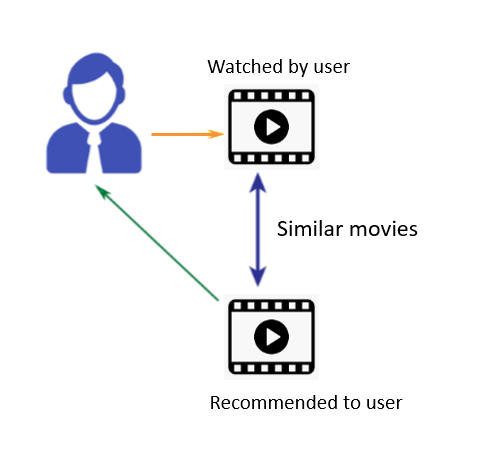](https://www.youtube.com/watch?v=nq2QtatuF7U&t=5s&ab_channel=NBCNews)

Click the picture above to watch a video about how Netflix makes recommendations! Try to find and point out where you see the three types of recommender systems we talked about earlier.

## Activity: What is content-based filtering and what data is important for it?

Content-based filtering uses data from one user. Usually, it looks like a recommendation based on something that user previously watched, listened to, or clicked on. We can use this method to make better recommendations that are more specific to an individual user!


### Exercise (Discussion)
Let's take another look at the features in our dataset. Run the cell below to see them! Using `dtypes` in pandas allows us to see all of the titles of our columns, which for us, are the features, as well as their data types.

In [ ]:
music_data.dtypes

artist_name           object
track_name            object
album                 object
track_id              object
track_popularity       int64
year                   int64
artist_popularity      int64
artist_followers       int64
genres                object
danceability         float64
energy               float64
key                    int64
loudness             float64
mode                   int64
speechiness          float64
acousticness         float64
instrumentalness     float64
liveness             float64
valence              float64
tempo                float64
duration_ms            int64
time_signature         int64
lyrics                object
hit_prediction         int64
dtype: object

**Which of these features might be useful when we're comparing songs?**

It's time to think about what features from this we might want to use for our model. Take a bit of time to discuss which ones seem reasonable and which might not be so relevant. You can always test out using different features later and see what songs get recommended or if they change!

### Discussion Solutions
<details>
<summary>Click to reveal!</summary>

1. Common categorical features: artist, genre
2. Common numerical features: danceability, track_popularity
3. There is no correct answer to this question. Students should try a variety of combinations.

</details>


### Exercise (Coding)
Fill in the list below with features that you think might be useful for figuring out similarities between songs! Make sure you're putting numerical features *(ie. any feature with ints/floats in the data)* and text-based features *(ie anything with words/letters)* in the right columns.

<font color="#de3023"><h3><b>Note: do not include `'lyrics'` in `text_features` or else you will run into RAM issues later on.</b></h3></font>


In [ ]:
numerical_features = [] # YOUR CODE HERE
text_features = [] # YOUR CODE HERE do not include 'lyrics'

In [ ]:
#@title Instructor Solution { display-mode: "form" }
numerical_features = ['danceability', 'track_popularity']
text_features = ['genres']

# this isn't an exact solution, they can choose whatever they want

## Activity: How do we transform the data to make it useful?




### Exercise (Coding)
Once we've decided on some features, we want to format our data so that we can use it. There are three steps here:
1. Combine our text features
2. Make a vector out of our combined text features
2. Add on our numerical features to the text vector



#### Step 1:
**To do the first step**, fill in the `combine_features` function that takes a row of our data (as a list) makes one combined `string` out of the relevant text features. Here's an example of how it might work:

Sample Input: `text_features = ['artist', 'track_name']`, a row of our data frame

Sample Output: `"Taylor Swift Wildest Dreams"`

In [ ]:
def combine_features(row):
    '''
    Loop through all of the features and make a string with all of them combined for one row
    '''
    combined_row = ''
    for feature in text_features:
      pass # YOUR CODE HERE (get rid of pass)

    return combined_row

In [ ]:
#@title Instructor Solution
def combine_features(row):
    '''
    Loop through all of the features and make a string with all of them combined for one row
    '''
    combined_row = ''
    for feature in text_features:
      combined_row += str(row[feature])
      combined_row += ' '
    return combined_row[:-1]

In [ ]:
#@title Run this cell to use your `combine_features` function!
# gets rid of null values
if 'genres' in text_features:
  music_data['genres'] = music_data['genres'].fillna('')
  music_data['genres'] = music_data.apply(fix_genres, axis=1)
for feature in text_features:
    music_data[feature] = music_data[feature].fillna('')
music_data["combined_features"] = music_data.apply(combine_features,axis=1)

After finishing the `combine_features` function, use the code cell below  to print out the song title and the new `combined_features` column to see what our new data looks like. **What do you notice?**

After printing it, try changing the `text_features` list from earlier and rerun the cells to see how it changes the data!

In [ ]:
# YOUR CODE HERE


In [ ]:
#@title Instructor Solution
music_data.head()

artist_name                           track_name  \
0      Miley Cyrus                  Party In The U.S.A.   
1  Waylon Jennings  The Year 2003 Minus 25 - Remastered   
2         Kid Cudi             Day 'N' Nite (nightmare)   
3           SHINee                       Ring Ding Dong   
4         Kid Cudi     Pursuit Of Happiness (Nightmare)   

                                     album                track_id  \
0                    The Time Of Our Lives  5Q0Nhxo0l2bP3pNjpGJwV1   
1                          Waylon & Willie  0sFq478LIo9BFwf2qzMzzF   
2          Man On The Moon: The End Of Day  5FEXPoPnzueFJQCPRIrC3c   
3  2009, Year Of Us - The Third Mini Album  4vLqN0bIxIQjlet2mIMBnx   
4          Man On The Moon: The End Of Day  5iSEsR6NKjlC9SrIJkyL3k   

   track_popularity  year  artist_popularity  artist_followers  \
0                74  2009                 89          14958283   
1                44  2009                 72            917987   
2                73  2009                 87           4787381   
3                59  2009                 73           2289681   
4                73  2009                 87           4787381   

                                              genres  danceability  energy  \
0                        dance pop pop post-teen pop         0.652   0.698   
1  country country rock outlaw country texas country         0.626   0.457   
2                           hip hop ohio hip hop rap         0.871   0.440   
3                              k-pop k-pop boy group         0.835   0.934   
4                           hip hop ohio hip hop rap         0.630   0.605   

   key  loudness  mode  speechiness  acousticness  instrumentalness  liveness  \
0   10    -4.667     0       0.0420       0.00112          0.000115    0.0886   
1    4   -13.785     1       0.0384       0.35500          0.000009    0.0668   
2   11    -6.250     0       0.0761       0.49900          0.000004    0.1140   
3    1    -1.258     1       0.0431       0.12500          0.000501    0.2220   
4    0    -8.951     1       0.0414       0.48400          0.000093    0.2980   

   valence    tempo  duration_ms  time_signature  \
0    0.470   96.021       202067               4   
1    0.474  102.166       184267               4   
2    0.799  137.996       221267               4   
3    0.811  124.980       233280               4   
4    0.266  115.277       295293               4   

                                              lyrics  hit_prediction  \
0  I hopped off the plane at L.A.X. with a dream ...               1   
1                                                NaN               0   
2  [Kid Cudi:] Day and night (what, what) I toss ...               1   
3  [Jonghyun] Baby Negae banhae beorin naegae wae...               1   
4  Crush a bit, little bit Roll it up, take a hit...               0   

                                   combined_features  
0                        dance pop pop post-teen pop  
1  country country rock outlaw country texas country  
2                           hip hop ohio hip hop rap  
3                              k-pop k-pop boy group  
4                           hip hop ohio hip hop rap

#### Step 2:
**To do the second step**, we're going to use the `CountVectorizer` (documentation [here!](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)) to make a vector out of our combined text features. Run the cell below to do this.

In [ ]:
cv = CountVectorizer()
count_matrix = cv.fit_transform(music_data["combined_features"]) # creates a vector out of our combined features

#### Step 3:
**To do the third step**, we're going to combine our numerical features with our vectorized text features. To do this, we have to add the numerical features for each song onto the existing text vector. Take a look at the cell below to see how we do this!

In [ ]:
text_vectors = count_matrix.toarray()
numerical = music_data[numerical_features].to_numpy()
# Next line scales numerical values so features like track_popularity and tempo don't outweigh everything else!
numerical = (numerical - numerical.min(axis=0)) / (numerical.max(axis=0) - numerical.min(axis=0))
song_vectors = np.concatenate((text_vectors, numerical), axis=1)

Let's take a look at our song vectors! Print them in the cell below. **What do you notice about the vectors?**

In [ ]:
# YOUR CODE HERE

In [ ]:
#@title Instructor Solution
print(song_vectors)

[[0.         0.         0.         ... 0.         0.66058764 0.74      ]
 [0.         0.         0.         ... 0.         0.63424519 0.44      ]
 [0.         0.         0.         ... 0.         0.88247214 0.73      ]
 ...
 [0.         0.         0.         ... 0.         0.75582573 0.        ]
 [0.         0.         0.         ... 0.         0.58358663 0.67      ]
 [0.         0.         0.         ... 0.         0.41742655 0.        ]]


## Instructor Solution
<details><summary>click to reveal!</summary>

The text part of the song vectors will be very sparse (mostly 0s). This is because we used a bag of words encoding to convert the text into numbers. The vocabulary will be large with the variety of words in our text data across all the songs, but each song will have few unique words in its text data, meaning they will have few nonzero values in the bag of words encoding.

## Activity: Similarity!
Now we're going to use a similarity function to see what songs are the most similar to each other! To do this, we'll first create vectors out of our data where each entry in the data set is its own vector.

After converting the data into vectors that we can measure, there are a few different ways we can measure similarity. In particular, we'll be talking about three:

*   Manhattan Distance
*   Euclidean Distance
*   Cosine Distance

Below are some diagrams describing each one, and [here's an article describing each metric and a few more](https://medium.com/@kunal_gohrani/different-types-of-distance-metrics-used-in-machine-learning-e9928c5e26c7#:~:text=Manhattan%20distance%20is%20usually%20preferred,similarity%20between%20two%20data%20points).

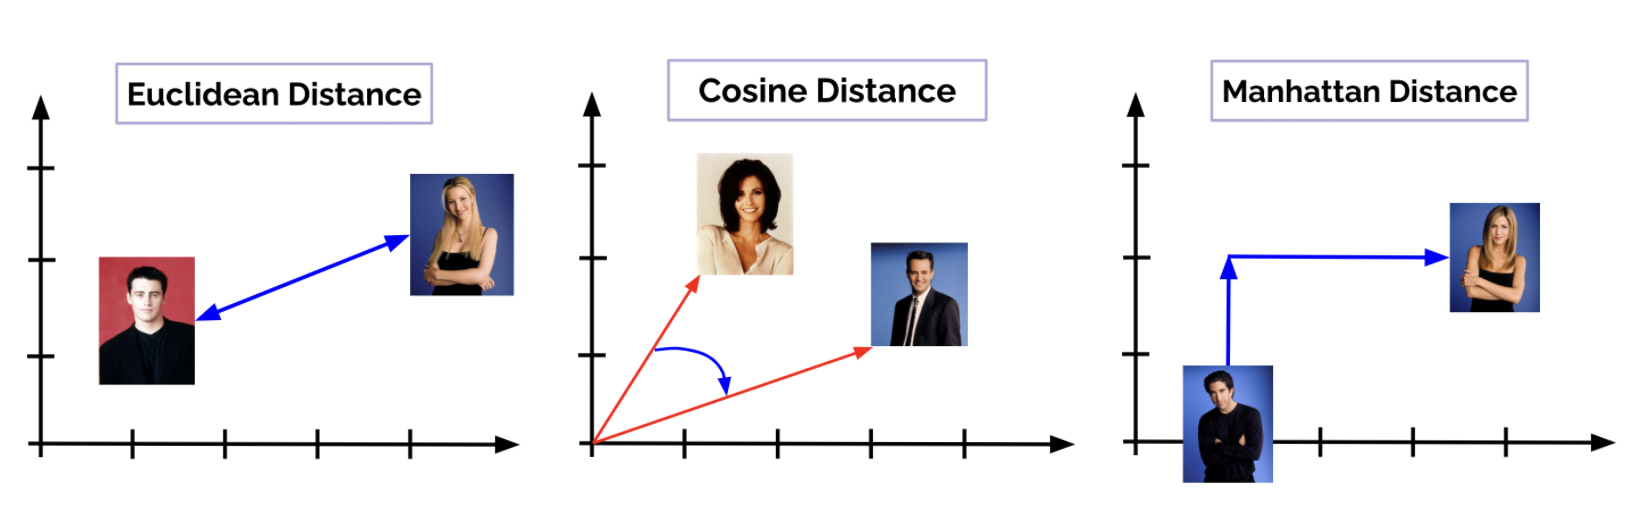

### Exercise (Discussion)
The most common metric for recommendation systems is **cosine similarity**, so that's what we'll have as our default.

The `all_similarity()` function below will give us the similarity scores between all the different songs in the data set using the cosine distance between vectors.

In [ ]:
def all_similarity(vectors, sim_metric='cosine'):
  if sim_metric == 'cosine':
    return cosine_similarity(vectors)
  else:
    # greater distance means the vectors are less similar, so we negate it
    return -pairwise_distances(vectors, metric=sim_metric)

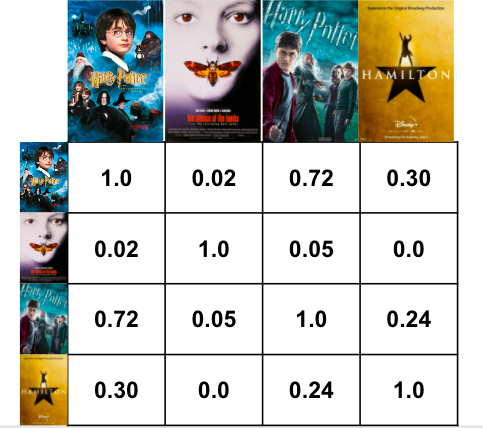

The result of the similarity function will look something like this (if our database was movies and only had *Harry Potter and the Philosopher's Stone*, *Silence of the Lambs*, *Harry Potter and the Half-Blood Prince*, and *Hamilton*).



**What do each of the numbers in the example above mean?**

**Why are all of the entries on the diagonals equal to one?**

**Does a larger number mean a song is more similar or less?**

### Discussion Solutions
<details>
<summary>Click to reveal!</summary>

1. Each of the numbers represents the cosine(theta) where theta is the angle between our song vectors.
2. If the songs are the same, theta = 0 and cos(0) = 1.0.
3. Cosine is larger for smaller angles so more similar songs have smaller angles and higher numbers.

</details>


### Exercise (Coding)
Use the `all_similarity` function to create the matrix and print it out. The `all_similarity` function takes two parameters. The first one is the song vectors that we created in the last activity, and the second is an optional parameter for our similarity metric, which can be one of three things:
* `'cosine'`
* `'euclidean'`
* `'manhattan'`

By default, it's set to use `'cosine'` (aka if you don't put in anything else, that's what it'll use).



In [ ]:
# YOUR CODE HERE


In [ ]:
#@title Instructor Solution
similarity_matrix = all_similarity(song_vectors, sim_metric='cosine')
print(similarity_matrix)


[[1.         0.04667906 0.09267676 ... 0.18332707 0.14644137 0.18332707]
 [0.04667906 1.         0.05916748 ... 0.14327649 0.08993674 0.14327649]
 [0.09267676 0.05916748 1.         ... 0.26238433 0.17875257 0.26238433]
 ...
 [0.18332707 0.14327649 0.26238433 ... 1.         0.34941715 1.        ]
 [0.14644137 0.08993674 0.17875257 ... 0.34941715 1.         0.34941715]
 [0.18332707 0.14327649 0.26238433 ... 1.         0.34941715 1.        ]]


Use the cell below this to print out the shape of the similarity matrix.

In [ ]:
# YOUR CODE HERE


In [ ]:
#@title Instructor Solution
print(similarity_matrix.shape)

(12112, 12112)


### Exercise (Discussion)
**What's the shape of the output? Why?**


### Discussion Solutions
<details>
<summary>Click to reveal!</summary>

Each song is given its own row and column! The number we find in each spot is the similarity score between the song corresponding to the specific row and the other song corresponding to the specific column. This is why we have ones along the diagonal: this is exactly where the row and column number (and thus the song) are the same!

</details>


### Exercise (Coding)


`all_similarity` gives us the overall similarity matrix, but how can we use that to find the similarity value between two songs? Fill in the function below called `similarity_score(track1, track2)` that will take in two songs and give us the similarity score between them.

Remember that similarity values in the matrix can only be accessed with the indices of the songs, not the song titles themselves! To get the index of a song, we've provided a function `find_index_from_title(song)` that will return the index of a given song.

In [ ]:
def similarity_score(track1, track2, similarity_matrix):
  if track1==None or track2==None:
    return None


  # YOUR CODE HERE (get rid of the score=0 line)
  score = 0

  return score

In [ ]:
#@title Instructor Solution
def similarity_score(track1, track2, similarity_matrix):
  if track1==None or track2==None:
    return None

  # YOUR CODE HERE (get rid of the score=0 line)
  song1_index = find_index_from_title(track1)
  song2_index = find_index_from_title(track2)
  score = similarity_matrix[song1_index][song2_index]

  return score

We're going to use the similarity score function to test the similarity between some songs! Use the cells below to choose songs and find the similarity score between them.

**Discussion Question:** What is the maximum and minimum possible similarity score if we're using cosine similarity?


### Discussion Solutions
<details>
<summary>Click to reveal!</summary>

The maximum similarity score would be 1, which is the same as cos(0), or the cosine of an angle of zero between the two songs (exactly the same).

The minimum score would be 0, but note that if we had negative values for any of our features, the cosine similarity could be negative.

</details>


In [ ]:
#@title Run this to choose your first song
song_1 = widgets.Combobox(
    placeholder='Choose a Song',
    options=available_songs,
    description='song1:',
    ensure_option=True,
    disabled=False)
song_1

Combobox(value='', description='song1:', ensure_option=True, options=('Party In The U.S.A., Miley Cyrus', 'The…

**Encountering RAM issues with these cells?** Go back to where you chose your text features and make sure you haven't accidentally included 'lyrics'

In [ ]:
#@title Run this to choose your second song
song_2 = widgets.Combobox(
    placeholder='Choose a Song',
    options=available_songs,
    description='song2:',
    ensure_option=True,
    disabled=False)
song_2

Combobox(value='', description='song2:', ensure_option=True, options=('Party In The U.S.A., Miley Cyrus', 'The…

In [ ]:
#@title Run this to process your song choices!
if song_1.value!='' and song_2.value!='':
  song1 = music_data['track_name'][available_songs.index(song_1.value)]
  song2 = music_data['track_name'][available_songs.index(song_2.value)]

Using the `song1` and `song2` variables, calculate the similarity with the `similarity_score` function and print it out using the cell below! Try to find some songs that are extremely similar (two songs that have a score over 0.4) and some that are really different (two songs that have a score under 0.1).

In [ ]:
# YOUR CODE HERE


In [ ]:
#@title Instructor Solution

print (similarity_score(song1, song2, similarity_matrix))

NameError: name 'song1' is not defined

In the cells below, try changing the features you're using to get the similarity score and testing the same songs.

**Try to get a feel for how the similarity scores will change based on which features you use!**

In [ ]:
numerical_features = [] # YOUR CODE HERE
text_features = [] # YOUR CODE HERE

In [ ]:
#@title Run this cell after updating your features in the cell above, then run your similarity_score() cell again!
# gets rid of null values
if 'genres' in text_features:
  music_data['genres'] = music_data['genres'].fillna('')
  music_data['genres'] = music_data.apply(fix_genres, axis=1)
for feature in text_features:
    music_data[feature] = music_data[feature].fillna('')
music_data["combined_features"] = music_data.apply(combine_features,axis=1)

# Make the combined vector out of text features
cv = CountVectorizer()
count_matrix = cv.fit_transform(music_data["combined_features"]) # creates a vector out of our combined features

# Adds numerical features to vector
text_vectors = count_matrix.toarray()
numerical = music_data[numerical_features].to_numpy()
# Next line scales numerical values so features like track_popularity and tempo don't outweigh everything else!
numerical = (numerical - numerical.min(axis=0)) / (numerical.max(axis=0) - numerical.min(axis=0))
song_vectors = np.concatenate((text_vectors, numerical), axis=1)

# Recalculate similarity matrix based on new song vectors
similarity_matrix = all_similarity(song_vectors, sim_metric='cosine')

## (Optional) Challenge Activity: K-Nearest Neighbors (KNN)

Now that we have information about the similarity between the songs in our data set, we can find the most similar songs and recommend those! Throughout this section, we've been building up to using the K-Nearest Neighbors or KNN algorithm. Take a look [at this link here](http://vision.stanford.edu/teaching/cs231n-demos/knn/) to visualize KNN on some data points.

### Exercise (Coding)
Now, we're going to finish this function to get `K` most similar songs to a given song. For example, if we call this function with `"Party in the U.S.A."` and `K=5`, then we should get the five songs most similar to "Party in the U.S.A." (not including "Party in the U.S.A."). To do this, we're going to need to complete a couple of steps.

**First**, we'll need to get the similarity matrix, the index of the song we're using, and the similarity values of that song and all the other songs. For now, our song can be "Party In The U.S.A.". At the end of running this cell, you should have a **list of floats** corresponding to the similarity values with that song against all other songs as vectors (ie `song_vectors`).

Sample Input: `'Party In The U.S.A.'`, `music_data`

Sample Output: `[0.5, 0.2, 0.9, 0.1, 0.83, 0.44, ......]`

In [ ]:
song = 'Party In The U.S.A.'

# YOUR CODE HERE

In [ ]:
#@title Instructor Solution
song = 'Party In The U.S.A.'

song_index = find_index_from_title(song)
song_similarity = similarity_matrix[song_index]


**Second**, we'll need to find the indices `K` maximum values in that list (not including 'Party In The U.S.A.'). For now, we can set our `K` to be 5.

At the end of running this cell, you should have a **list of integers** corresponding to the indices of the max similarity values (not including the one corresponding to the original song).

Sample Input: `[0.5, 0.2, 0.9, 0.1, 0.83, 0.44, ......]`, `K=3`

Sample Output: `[2, 4, 0]`

*Hint: Use a for loop!*

In [ ]:
K = 5

# YOUR CODE HERE

In [ ]:
#@title Instructor Solution
K = 5

# using a loop
song_indices = []

for i in range(0, K):
  current_max = 0
  current_index = None
  for j in range(len(song_similarity)):
    if song_similarity[j] > current_max and j not in song_indices and j != song_index:
      current_max = song_similarity[j]
      current_index = j
  song_indices.append(current_index)

# using sorting
similar_songs = list(enumerate(song_similarity))
sorted_similar_songs = sorted(similar_songs,key=lambda x:x[1],reverse=True)[1:]
song_indices = [x[0] for x in sorted_similar_songs[:K]]


**Finally**, we need to convert these indices back into song titles to see our recommendations! Use the cell below to get the names of the song and the artist who sings that song

*(HINT: there are 2 relevant functions -  `find_title_from_index` and `find_artist_from_index`).*

In [ ]:
song_names = []
singers = []

# YOUR CODE HERE

In [ ]:
#@title Instructor Solution
song_names = []
singers = []

for index in song_indices:
  song_names.append(find_title_from_index(index))
  singers.append(find_artist_from_index(index))

Once you've finished all of the steps, use that code to fill in the `k_most_similar_songs` function below!

In [ ]:
def k_most_similar_songs(song, song_vectors, K):
  # YOUR CODE HERE

  return []

In [ ]:
#@title Instructor Solution

def k_most_similar_songs(song, song_vectors, K):
  song_index = find_index_from_title(song)
  song_similarity = similarity_matrix[song_index]

  song_indices = []

  for i in range(0, K):
    current_max = 0
    current_index = None
    for j in range(len(song_similarity)):
      if song_similarity[j] > current_max and j not in song_indices and j != song_index:
        current_max = song_similarity[j]
        current_index = j
    song_indices.append(current_index)

  song_names = []
  singers = []
  for index in song_indices:
    song_names.append(find_title_from_index(index))
    singers.append(find_artist_from_index(index))
  return song_names, singers


And now we're done! Try using the function to find songs similar to ones you like!

In [ ]:
#@title Run this to choose a song
song = widgets.Combobox(
    placeholder='Choose a Song',
    options=available_songs,
    description='Song:',
    ensure_option=True,
    disabled=False)
song

In [ ]:
# Run this to get your recommended songs!
song_name = music_data['track_name'][available_songs.index(song.value)]
similar_songs, similar_artists = k_most_similar_songs(song_name, song_vectors, 10)
print(similar_songs)
print(similar_artists)

## What did we do here?
We made two types of recommendation systems: one where we recommend popular songs by genre and one where we're recommending songs based on a song that the user has previously listened to.

# (Optional) Milestone 4: Streamlit!
The goal of this session is to learn how to deploy the models that we have been training to the web so they can be shared with the world!
Take a moment to look through examples of websites built with Streamlit [here](https://streamlit.io/gallery?category=favorites). As a class, choose your favorite and answer the following **questions:**
* Who is this application for?
* How does the user input data - are these intuitive ways of interacting with the app?
* What does the application do with the data?
* Evaluate the ease of use and look of the application.
Now that we’ve seen what is possible with Streamlit, let’s try to deploy our **Music Recommender System** to the web!

Feel free to also use this [Streamlit cheat sheet](https://docs.streamlit.io/library/cheatsheet) as a toolbox to use Streamlit to customize your site!

In [ ]:
#@title First, run this to set up Streamlit!

# need this line otherwise we get OOM and the notebook will crash
del similarity_matrix
print("Setting up Streamlit...")
#print("Don't worry if you see ERROR here!")
!pip -q install streamlit
!pip -q install pyngrok
from pyngrok import ngrok

!wget 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Music%20Recommendation/data_with_most_lyrics.csv'
!wget 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Music%20Recommendation/spotify_data_urls.csv'

def launch_website():
  print ("Click this link to try your web app:")
  if (ngrok.get_tunnels() != None):
    ngrok.kill()
  tunnel = ngrok.connect() # The URL to connect to
  print (tunnel.public_url)
  !streamlit run --server.port 80 app.py >/dev/null # Connect to the URL through Port 80 (>/dev/null hides outputs)

print("Done!")


<font color=SlateGrey><h2><b>
You will need an ngrok authtoken to run Streamlit. Follow [these](https://drive.google.com/file/d/12zwuOuKh91VSHIHS-6S4ADF4HLC2wKJq/view?usp=sharing) instructions to get yours!
</b></h2></font>

<font color=DarkGray><h3><b>
Paste your authtoken below next to `!ngrok authtoken`!
</b></h3></font>

In [ ]:
!ngrok authtoken #Paste your authtoken here

In [ ]:
#@title Instructor Tokens
#@markdown Use these sparingly, as only one person can use each at a time!

!ngrok authtoken 2esTEyBVYVUkNTh0ETgpZq6ThNH_RzyMevymuyYSKd76mSY7
# !ngrok authtoken 2esTQObOz9XZ2be2DF4aPlS3upu_88X3yovgR3x3NFNAVTvVf
# !ngrok authtoken 2PfMYFZgmz9KLqLlZ4Pn7Bqa8ZA_3vMo1vufxRTWJLHhDHUBC

## Activity: Customizing your Streamlit app!
Let's set up the heading of our app by adding a title, name, and description!
We recommend using functions like ```st.title()```, ```st.header()```, and ```st.subheader()```, and ```st.write()```.

1. First, let's set up the name of your recommender system.

2. Next, write your name under the title. You can also use a fake name or alias if you prefer.

3. Now, write a description outlining who this recommendation system would be useful for and what it can do!

*Tip*: In all the cells below, you can comment out the first line to get the formatting back for easier coding. Make sure you uncomment before running!

In [ ]:
%%writefile header.py
import streamlit as st
import streamlit.components.v1 as components

def create_header():
  ### FILL IN YOUR CODE FOR TITLE, NAME, AND DESCRIPTION HERE
  pass


In [ ]:
#@title Instructor Solution
%%writefile header.py
import streamlit as st
import streamlit.components.v1 as components

def create_header():
  st.title("Recommendation System")
  st.header("By Jane Doe")
  st.subheader("This recommender system ...")

Now, let's add some responses for our app! Once our app makes a recommendation, it can help send a message depending on the song(s) that are recommended. For now, lets just have it respond with the recommended songs and their artists.

In [ ]:
%%writefile response.py
import streamlit as st
import streamlit.components.v1 as components

def get_app_response(recommended_songs, recommended_artists):
  if recommended_songs is not None:
    st.write("FILL ME IN")
    # YOUR CODE HERE

In [ ]:
#@title Instructor Solution

# they can really do this however they want
%%writefile response.py
import streamlit as st
import streamlit.components.v1 as components

def get_app_response(recommended_songs, recommended_artists):
  if recommended_songs is not None:
    for i in range(len(recommended_songs)):
      st.write(recommended_songs[i] + ' by ' + recommended_artists[i])

## Activity: Popular Recs in Streamlit

Now that we've done this, we need to consolidate some of the code we've written above into functions so we can use them later! Let's start with a function that does popular recommendations (or recommendations by top hit if you got to that section)!

We have a function outline below that takes in the chosen genre, the number of songs we want to give the user (`K`), and an optional parameter called `method` defaulted to "popularity". This can be used to switch between recommending by popularity value (using "popularity") or recommending by top hit prediction (using "hit_prediction") if you were able to do that section. **This function should return the `K` recommended songs and their artists as two separate lists.**

*If you weren't able to do hit prediction recommendation in this notebook, change the code accordingly. If you were, remember that you have to re-create your model and the process of adding the hit/not hit values to the data in this function.*

In [ ]:
%%writefile helper.py
import streamlit as st
import streamlit.components.v1 as components
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Music data
music_data = pd.read_csv('data_with_most_lyrics.csv')
music_data = music_data.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])
music_data['lyrics'] = music_data['lyrics'].str.replace('\n', ' ')
available_songs = music_data["track_name"] + ', ' + music_data["artist_name"]
available_songs = available_songs.tolist()

# Past music data
past_data = pd.read_csv('spotify_data_urls.csv')

def find_title_from_index(index):
    return music_data["track_name"][index]
def find_artist_from_index(index):
    return music_data["artist_name"][index]
def find_index_from_title(track_name):
    return music_data.index[music_data.track_name == track_name].values[0]
# end imports

###########################
# FUNCTION YOU'RE EDITING #
###########################

def top_song_recs(data, genre, K, method='track_popularity'):
  # separating genre values
  separated_genres = separate_values('genres')

  # segmenting data based on chosen genre
  genre_tracks = None
  if genre.value!=None:
    genre_tracks = separated_genres.loc[separated_genres['genres'] == genre]

    # YOUR CODE HERE (replace the None)
    if method == 'hit_prediction':
      # YOUR CODE HERE
      pass
    else:
      # YOUR CODE HERE
      pass

  return None, None

###############################
# END FUNCTION YOU'RE EDITING #
###############################

def parse_string_into_list(string):
  return string[1:len(string)-1].split(', ')

def separate_values(column):
  mdata = music_data.copy()
  mdata[column] = mdata.apply(lambda row: parse_string_into_list(row[column]), axis=1)
  mdata.head()

  mdata = mdata.explode(column)
  return mdata


In [ ]:
#@title Instructor Solution
%%writefile helper.py
import streamlit as st
import streamlit.components.v1 as components
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Music data
music_data = pd.read_csv('data_with_most_lyrics.csv')
music_data = music_data.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])
music_data['lyrics'] = music_data['lyrics'].str.replace('\n', ' ')
available_songs = music_data["track_name"] + ', ' + music_data["artist_name"]
available_songs = available_songs.tolist()

# Past music data
past_data = pd.read_csv('spotify_data_urls.csv')

def find_title_from_index(index):
    return music_data["track_name"][index]
def find_artist_from_index(index):
    return music_data["artist_name"][index]
def find_index_from_title(track_name):
    return music_data.index[music_data.track_name == track_name].values[0]
# end imports

###########################
# FUNCTION YOU'RE EDITING #
###########################

def top_song_recs(genre, K, method='track_popularity'):
  separated_genres = separate_values('genres')
  # segmenting data based on chosen genre
  genre_tracks = None
  if genre!=None:
    genre_tracks = separated_genres.loc[separated_genres['genres'] == genre]

    # YOUR CODE HERE (replace the None)
    if method == 'hit_prediction':
      X = past_data[['danceability','energy','key','loudness','mode','speechiness','acousticness','instrumentalness','liveness','valence','tempo']]
      y = past_data[['Label']]

      # YOUR CODE HERE
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

      lr = LogisticRegression()
      lr.fit(X_train,y_train)

      X_new = genre_tracks[['danceability','energy','key','loudness','mode','speechiness','acousticness','instrumentalness','liveness','valence','tempo']]
      genre_tracks['hit_prediction'] = lr.predict(X_new)

      genre_hits = genre_tracks.loc[genre_tracks['hit_prediction'] == 1][:K]
    else:
      genre_hits = genre_tracks.sort_values('track_popularity', ascending=False)[:K]

    return genre_hits['track_name'].tolist(), genre_hits['artist_name'].tolist()
  return None, None

###############################
# END FUNCTION YOU'RE EDITING #
###############################

def parse_string_into_list(string):
  return string[1:len(string)-1].split(', ')

def separate_values(column):
  mdata = music_data.copy()
  mdata[column] = mdata.apply(lambda row: parse_string_into_list(row[column]), axis=1)
  mdata.head()

  mdata = mdata.explode(column)
  return mdata


## Activity: Content-Based Recommendation in Streamlit

Now we're going to do the same thing for content-based recommendation. In the cell below, paste in your `k_most_similar_songs` function.

In [ ]:
%%writefile contentbased.py
import streamlit as st
import streamlit.components.v1 as components
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Music data
music_data = pd.read_csv('data_with_most_lyrics.csv')
music_data = music_data.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])
music_data['lyrics'] = music_data['lyrics'].str.replace('\n', ' ')
available_songs = music_data["track_name"] + ', ' + music_data["artist_name"]
available_songs = available_songs.tolist()

# Past music data
past_data = pd.read_csv('spotify_data_urls.csv')

def find_title_from_index(index):
    return music_data["track_name"][index]
def find_artist_from_index(index):
    return music_data["artist_name"][index]
def find_index_from_title(track_name):
    return music_data.index[music_data.track_name == track_name].values[0]
# end imports

###############################
# PASTE IN YOUR FUNCTION HERE #
###############################


#####################
# END FUNCTION HERE #
#####################

def combine_features(row, text_features = []):
    combined_row = ''
    for feature in text_features:
      combined_row += str(row[feature])
      combined_row += ' '
    return combined_row[:-1]

def data_formatting(text_features, numerical_features):
  if 'genres' in text_features:
    music_data['genres'] = music_data['genres'].fillna('')
    # music_data['genres'] = music_data.apply(fix_genres, axis=1)
  for feature in text_features:
      music_data[feature] = music_data[feature].fillna('')
  music_data["combined_features"] = music_data.apply(lambda row: combine_features(row, text_features=text_features),axis=1)

  cv = CountVectorizer()
  count_matrix = cv.fit_transform(music_data["combined_features"]) # creates a vector out of our combined features

  text_vectors = count_matrix.toarray()
  numerical = music_data[numerical_features].to_numpy()
  song_vectors = np.concatenate((text_vectors, numerical), axis=1)
  return song_vectors


def all_similarity(vectors, sim_metric='cosine'):
  if sim_metric == 'cosine':
    return cosine_similarity(vectors)
  else:
    # greater distance means the vectors are less similar, so we negate it
    return -pairwise_distances(vectors, metric=sim_metric)

In [ ]:
#@title Instructor Solution
%%writefile contentbased.py
import streamlit as st
import streamlit.components.v1 as components
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Music data
music_data = pd.read_csv('data_with_most_lyrics.csv')
music_data = music_data.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])
music_data['lyrics'] = music_data['lyrics'].str.replace('\n', ' ')
available_songs = music_data["track_name"] + ', ' + music_data["artist_name"]
available_songs = available_songs.tolist()

# Past music data
past_data = pd.read_csv('spotify_data_urls.csv')

def find_title_from_index(index):
    return music_data["track_name"][index]
def find_artist_from_index(index):
    return music_data["artist_name"][index]
def find_index_from_title(track_name):
    return music_data.index[music_data.track_name == track_name].values[0]
# end imports

###############################
# PASTE IN YOUR FUNCTION HERE #
###############################

def k_most_similar_songs(song, song_vectors, K):
  similarity_matrix = all_similarity(song_vectors)
  song_index = find_index_from_title(song)
  song_similarity = similarity_matrix[song_index]

  song_indices = []
  for i in range(0, K):
    current_max = 0
    current_index = None
    for j in range(len(song_similarity)):
      if song_similarity[j] > current_max and j not in song_indices and j != song_index:
        current_max = song_similarity[j]
        current_index = j
    song_indices.append(current_index)

  song_names = []
  singers = []
  for index in song_indices:
    song_names.append(find_title_from_index(index))
    singers.append(find_artist_from_index(index))
  return song_names, singers

#####################
# END FUNCTION HERE #
#####################

def combine_features(row, text_features=[]):
    combined_row = ''
    for feature in text_features:
      combined_row += str(row[feature])
      combined_row += ' '
    return combined_row[:-1]

def data_formatting(text_features, numerical_features):
  if 'genres' in text_features:
    music_data['genres'] = music_data['genres'].fillna('')
    # music_data['genres'] = music_data.apply(fix_genres, axis=1)
  for feature in text_features:
      music_data[feature] = music_data[feature].fillna('')
  music_data["combined_features"] = music_data.apply(lambda row: combine_features(row, text_features=text_features),axis=1)

  cv = CountVectorizer()
  count_matrix = cv.fit_transform(music_data["combined_features"]) # creates a vector out of our combined features

  text_vectors = count_matrix.toarray()
  numerical = music_data[numerical_features].to_numpy()
  song_vectors = np.concatenate((text_vectors, numerical), axis=1)
  return song_vectors


def all_similarity(vectors, sim_metric='cosine'):
  if sim_metric == 'cosine':
    return cosine_similarity(vectors)
  else:
    # greater distance means the vectors are less similar, so we negate it
    return -pairwise_distances(vectors, metric=sim_metric)

## Combining all our functions and setting up web interface!

In [ ]:
#@title Run this to put everything together!
%%writefile app.py
import streamlit as st
import streamlit.components.v1 as components

import pandas as pd
import numpy as np
import tensorflow as tf
import cv2
from header import *
from response import *
from helper import *
from contentbased import *

create_header()

def get_song_recs(rec_method, text_features, numerical_features, song, genre, K):
  if rec_method == "Popular Songs":
    return top_song_recs(genre, K)
  elif rec_method == "Predicted Top Hits":
    return top_song_recs(genre, K, method='hit_prediction')
  else:
    if song is not None and song is not []:
      song_vectors = data_formatting(text_features, numerical_features)
      return k_most_similar_songs(song, song_vectors, K)
    return None, None


choice = st.radio("Choose recommendation method: ", ["Popular Songs", "Predicted Top Hits", "Content-Based Recommendation"])
if choice == "Content-Based Recommendation":
  left_column, m1, m2 = st.columns((1,1,1))
  with left_column:
    k = st.slider("Pick a value for K", 1, 20)

  genre = None
  with m1:
    avail_text_feat = ['artist_name', 'track_name', 'album', 'genres']
    text_features = st.multiselect("Pick your text features!", avail_text_feat)
  with m2:
    avail_num_feat = ['track_popularity', 'year', 'artist_popularity', 'artist_followers', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness','acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo','duration_ms', 'time_signature']
    numerical_features = st.multiselect("Pick your numerical features!", avail_num_feat)

  select = st.multiselect("Pick a song!", available_songs, default = None)
  if select == []:
    song = None
  else:
    song = music_data['track_name'][available_songs.index(select[0])]
else:
  left_column, right_column = st.columns(2)
  with left_column:
    k = st.slider("Pick how many songs you want to see!", 1, 20)
  with right_column:
    available_genres = separate_values('genres')['genres'].value_counts().index.tolist()
    select = st.multiselect("Pick a genre!", available_genres)
    if select == []:
      genre = None
    else:
      genre = select[0]
  song = None
  text_features, numerical_features = None, None

recs, artists = get_song_recs(choice, text_features, numerical_features, song, genre, k)
get_app_response(recs, artists)


Finally, let's launch our app!
Run this block, then click the URL to access your webpage: it'll be accessible until you stop the code block. You can also check it out on your phone.

**Note: Predicted Top Hits and Content-Based Recommendation may take a LONG time to run**
(*keep an eye on the little man running in the top right of the screen*)

**Tips**
*   Stick to small numbers song numbers, text/numerical features.
*   Exit out of and relaunch website if you encounter errors or runtime surpasses 2 minutes.



In [ ]:
launch_website()

## Want to go further?

**Here are some ideas for what you can do:**
* List out the songs for the user to see from highest recommended to lowest along with their scores or similarity values
* Mention the most common genre between all the songs recommended
* If any of the songs have overlapping cast members or directors, you can mention that also!
* Anything else relating to the song selection!
* Add additional custom Streamlit components into your app! Check out the [Streamlit Cheat Sheet](https://docs.streamlit.io/library/cheatsheet) and some suggestions below.

In [ ]:
#Your Streamlit Toolbox!

"""
#Write text
st.write("text")

#Title
st.title('title')

#Header
st.header('header')

#Slider
value = st.slider('variable')

#Table
st.table(dataframe) #use a Pandas DataFrame

#Bar Chart (Example)
chart_data = pd.DataFrame({"predictions": predictions}, index = class_names)
st.bar_chart(chart_data)

#Matplotlib Figure
st.pyplot(fig) #use a Matplotlib figure

#Image
st.image(image, caption='Image Caption')

#Button
pressed = st.button('Button Name')

#Checkbox
checked = st.checkbox('Checkbox Name')

#File Input
uploaded_file = st.file_uploader("Upload File")

if uploaded_file is not None:
    pass #Do something here!

"""